In [20]:
pip install transformers datasets

Note: you may need to restart the kernel to use updated packages.


In [21]:
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


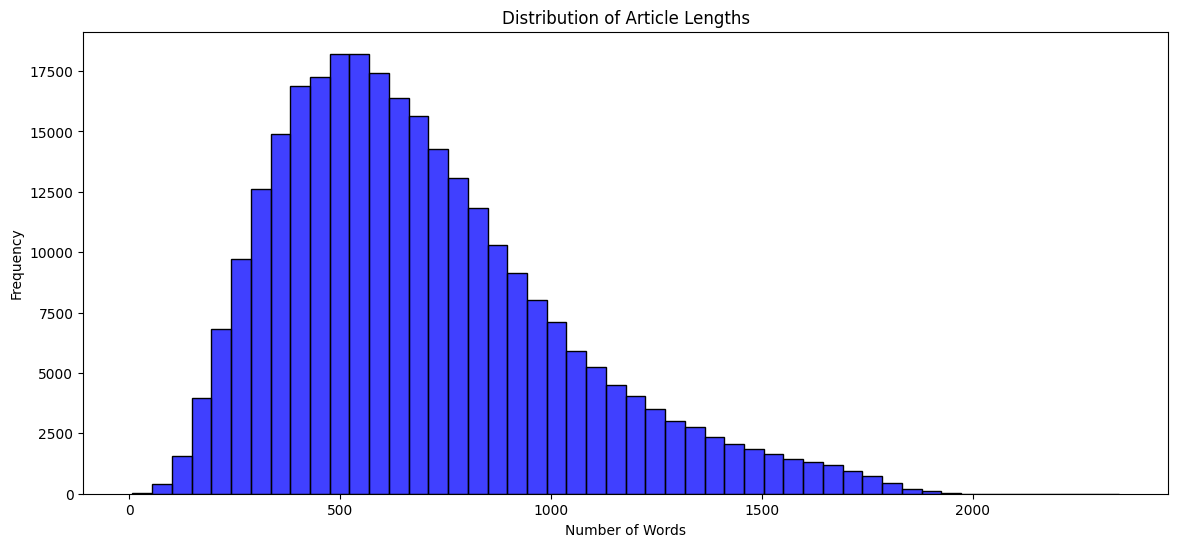

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


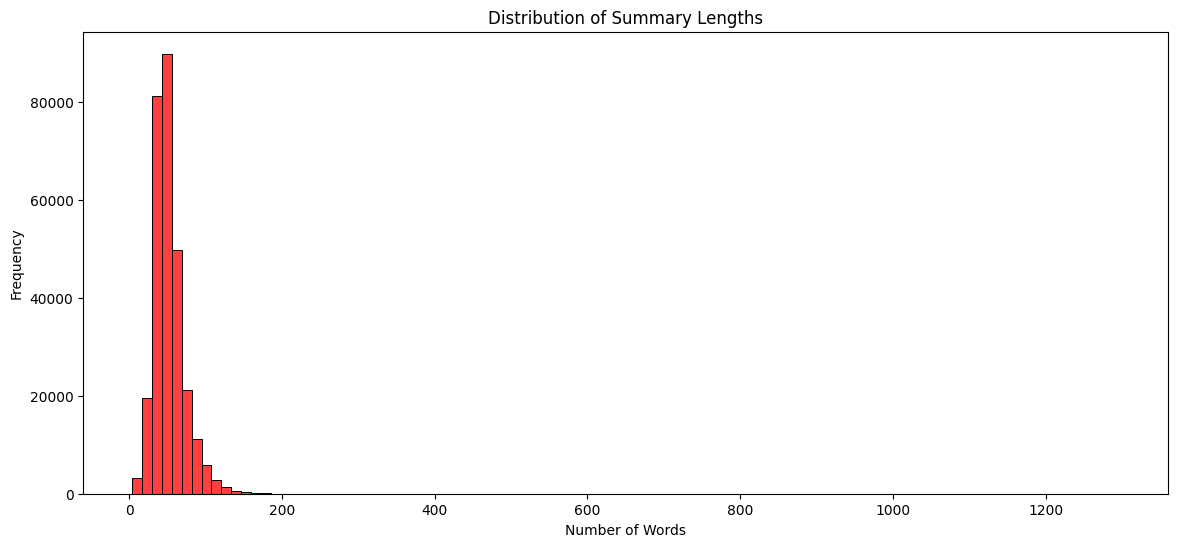

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


# Compute lengths
article_lengths = [len(article.split()) for article in dataset['train']['article']]
summary_lengths = [len(summary.split()) for summary in dataset['train']['highlights']]

# Plotting Article Lengths
plt.figure(figsize=(14, 6))
sns.histplot(article_lengths, bins=50, color='blue')
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Plotting Summary Lengths
plt.figure(figsize=(14, 6))
sns.histplot(summary_lengths, bins=100, color='red')
plt.title('Distribution of Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

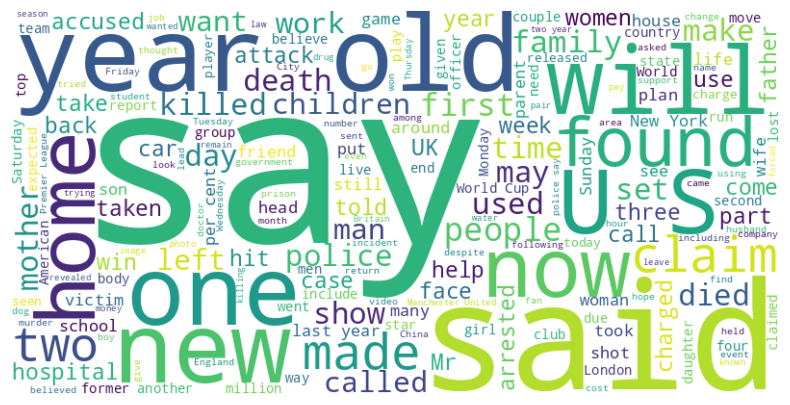

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all summaries
text = " ".join(summary for summary in dataset['train']['highlights'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [24]:
from transformers import BartTokenizer, BartForConditionalGeneration

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

In [29]:
def preprocess_function(examples):
    # Tokenize articles and highlights without truncation
    inputs = tokenizer(examples['article'], padding='max_length', max_length=1801, truncation=False)
    labels = tokenizer(examples['highlights'], padding='max_length', max_length=150, truncation=False)

    # Ensure that labels are padded to the same length
    inputs['labels'] = labels['input_ids']
    return inputs
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [30]:
from transformers import Trainer, TrainingArguments


# Define training arguments
training_args = TrainingArguments(c  
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',
    report_to="none",
    remove_unused_columns=False,
)

# Initialize Trainer
trainer = Trainer(
    model=model.to('cpu'),
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
)

# Start training
trainer.train()

IndexError: index out of range in self

In [32]:
print(model.config.vocab_size)


50264


In [34]:

# Tokenize a sample input
inputs = tokenizer("Hello, how are you?", return_tensors="pt")
print("Input IDs:", inputs['input_ids'])

# Check token IDs range
vocab_size = tokenizer.vocab_size
print("Vocab Size:", vocab_size)
if (inputs['input_ids'] >= vocab_size).any():
    raise ValueError("Some token IDs are out of range")

Input IDs: tensor([[    0, 31414,     6,   141,    32,    47,   116,     2]])
Vocab Size: 50265


In [31]:
# Inspect the dataset fields
print(tokenized_datasets['train'].features)


{'article': Value(dtype='string', id=None), 'highlights': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [11]:
# Inspect a few entries
print(dataset['train'][0])


{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char